In [1]:
import pandas as pd
import csv
import time
import numpy as np
import re
import os

import sys
sys.path.insert(0, '../')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

import collections
from collections import defaultdict

import nltk
nltk.download('stopwords')
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
stemmer = PorterStemmer()
import gensim
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 
import plotly
import plotly.graph_objs as go


### STS benchmark

In [2]:
col_names=['genre', 'file', 'year', 'feature_1','feature_2', 'sentence_1', 'sentence_2', 'feature_3','feature_4']

df_train_sts=pd.read_excel('/Users/mariabrullmartinez/Documents/TFM-NLP/EDA/stsbenchmark/sts-train.xls', header=None, names=col_names)
df_train_sts["sent1_length"]= df_train_sts["sentence_1"].str.len()
df_train_sts["sent2_length"]= df_train_sts["sentence_2"].str.len()

df_test_sts=pd.read_excel('/Users/mariabrullmartinez/Documents/TFM-NLP/EDA/stsbenchmark/sts-test.xls', header=None, names=col_names)
df_test_sts["sent1_length"]= df_test_sts["sentence_1"].str.len()
df_test_sts["sent2_length"]= df_test_sts["sentence_2"].str.len()

df_dev_sts=pd.read_excel('/Users/mariabrullmartinez/Documents/TFM-NLP/EDA/stsbenchmark/sts-dev.xls', header=None, names=col_names)
df_dev_sts["sent1_length"]= df_dev_sts["sentence_1"].str.len()
df_dev_sts["sent2_length"]= df_dev_sts["sentence_2"].str.len()

df_sts=pd.concat([df_train_sts, df_test_sts, df_dev_sts])

In [3]:
print ('The lenght of the train dataset is :', df_train_sts.shape)
print ('The lenght of the test dataset is :', df_test_sts.shape)
print ('The lenght of the dev dataset is :', df_dev_sts.shape)
print ('The lenght of the total dataset is :', df_sts.shape)

The lenght of the train dataset is : (5749, 11)
The lenght of the test dataset is : (1379, 11)
The lenght of the dev dataset is : (1500, 11)
The lenght of the total dataset is : (8628, 11)


### SICK benchmark

In [4]:
df_sick = pd.read_csv("/Users/mariabrullmartinez/Documents/TFM-NLP/EDA/SICK/SICK.txt", sep='\t')

In [5]:
df_sick=df_sick.drop('sentence_B_original', axis=1)

In [6]:
df_test_sick=df_sick.loc[df_sick['SemEval_set']=='TEST']
df_train_sick=df_sick.loc[df_sick['SemEval_set']=='TRAIN']
df_trial_sick=df_sick.loc[df_sick['SemEval_set']=='TRIAL']

In [7]:
print ('The lenght of the train dataset is :', df_train_sick.shape)
print ('The lenght of the test dataset is :', df_test_sick.shape)
print ('The lenght of the dev dataset is :', df_trial_sick.shape)
print ('The lenght of the total dataset is :', df_sick.shape)

The lenght of the train dataset is : (4439, 11)
The lenght of the test dataset is : (4906, 11)
The lenght of the dev dataset is : (495, 11)
The lenght of the total dataset is : (9840, 11)


#### Lets try to have a balance dataset for both database, therefore we will establish: 
- train: 6000 sentences
- test: 2500 sentences 
- trial: 500 sentences

In [8]:
df_test_sts=pd.concat([df_dev_sts[0:700], df_test_sts])


In [8]:
df_train_sts=pd.concat([df_dev_sts[700:1000], df_train_sts])

In [9]:
df_dev_sts=df_dev_sts[1000:]

In [10]:
print ('The lenght of the train dataset is :', df_train_sts.shape)
print ('The lenght of the test dataset is :', df_test_sts.shape)
print ('The lenght of the dev dataset is :', df_dev_sts.shape)
print ('The lenght of the total dataset is :', df_sts.shape)

The lenght of the train dataset is : (6049, 11)
The lenght of the test dataset is : (1379, 11)
The lenght of the dev dataset is : (500, 11)
The lenght of the total dataset is : (8628, 11)


In [11]:
df_train_sick=pd.concat([df_test_sick[0:1700], df_train_sick])

In [12]:
df_test_sick=df_test_sick[2000:4000]

In [13]:
print ('The lenght of the train dataset is :', df_train_sick.shape)
print ('The lenght of the test dataset is :', df_test_sick.shape)
print ('The lenght of the dev dataset is :', df_trial_sick.shape)
print ('The lenght of the total dataset is :', df_sick.shape)

The lenght of the train dataset is : (6139, 11)
The lenght of the test dataset is : (2000, 11)
The lenght of the dev dataset is : (495, 11)
The lenght of the total dataset is : (9840, 11)


### Data Preprocessing

In [17]:
STOP_WORDS = nltk.corpus.stopwords.words()
 

In [18]:
def clean_sentence(val):
    #regex = re.compile('([^\s\w]|_)+')
    sentence = val.lower()
    sentence = sentence.split(" ")
   
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word) 
            
    sentence = " ".join(sentence)
    return sentence

In [230]:
def clean_dataframe(data, colum):
    data = data.dropna(how="any")
   
    for col in [colum]:
        data['sentence_A_clean'] = data[col].apply(clean_sentence)
        data['sentence_A_clean'].replace(" ", "_")
   
    return data
 

In [231]:
data=clean_dataframe(df_test_sick, 'sentence_A')

In [211]:
len(data['sentence_A'].unique())

1193

In [22]:
def build_corpus(data, colum):
    corpus = []
    for col in [colum]:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
           
    return corpus

In [23]:
corpus=build_corpus(data, 'sentence_A')

In [43]:
len(corpus)

2000

### Apply model 

In [92]:
model = word2vec.Word2Vec(corpus, size=100, min_count=1, workers=4)

In [93]:
model.train(corpus, total_examples=model.corpus_count, epochs=30, report_delay=1)

(207939, 270840)

In [212]:
vocab=model.wv.vocab

### Obtain the vector per sentence

In [214]:
def get_dict_corpus(vocab, model):
    
    
    dict_word_2_vect={}
    dict_corpus_2_vect={}

    ## create the dictionary of the words and its vector 
    for idx, key in enumerate(vocab):
        dict_word_2_vect[key]=model.wv.get_vector(key)
        
   ## create the dictionary for the corpus and its vector  
    for elem in corpus: 
        list_prod_elem=[]
        for ele in elem:
            if ele in dict_word_2_vect: 
                vector_ele=dict_word_2_vect[ele]
                list_prod_elem.append(vector_ele)
            dict_corpus_2_vect[tuple(elem)]=list_prod_elem

    return dict_corpus_2_vect

In [215]:
dict_corpus_2_vect=get_dict_corpus(vocab,model)

In [207]:
len(dict_corpus_2_vect)

1193

In [256]:
df=pd.DataFrame.from_dict(dict_corpus_2_vect, orient='index').reset_index()

In [257]:
df

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,"(stopping, horse)","[-0.012819192, 0.019429363, -0.044940826, 0.03...","[0.024915896, 0.017940965, -0.108109474, 0.140...",None,None,None,None,None,None,None,None,None,None,None,None
1,"(riding, horse)","[0.008061746, -0.00086911744, -0.008685483, 0....","[0.024915896, 0.017940965, -0.108109474, 0.140...",None,None,None,None,None,None,None,None,None,None,None,None
2,"(horse, riding)","[0.024915896, 0.017940965, -0.108109474, 0.140...","[0.008061746, -0.00086911744, -0.008685483, 0....",None,None,None,None,None,None,None,None,None,None,None,None
3,"(horse, ridden)","[0.024915896, 0.017940965, -0.108109474, 0.140...","[-0.015295827, 0.047418963, -0.10524734, 0.125...",None,None,None,None,None,None,None,None,None,None,None,None
4,"(person, drawing)","[0.038300216, 0.04570991, -0.12934853, 0.15979...","[-0.0072772405, 0.09262297, -0.18152039, 0.156...",None,None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,"(yellow, drinking, water, faucet)","[-0.13525006, 0.10421255, -0.326289, 0.1795338...","[-0.032130074, 0.064197354, -0.13217525, 0.089...","[-0.028812831, 0.11876937, -0.25149724, 0.1938...","[-0.024106463, 0.043171115, -0.091355614, 0.06...",None,None,None,None,None,None,None,None,None,None
1189,"(, water, faucet, drunk, yellow)","[-0.0143091, 0.03168435, -0.07219432, 0.054119...","[-0.028812831, 0.11876937, -0.25149724, 0.1938...","[-0.024106463, 0.043171115, -0.091355614, 0.06...","[-0.04235771, 0.08126763, -0.18146475, 0.12152...","[-0.13525006, 0.10421255, -0.326289, 0.1795338...",None,None,None,None,None,None,None,None,None
1190,"(adults, children, gathered, near, outdoor, se...","[-0.03727561, 0.060518764, -0.13392445, 0.0696...","[-0.102547385, 0.14451179, -0.30383486, 0.1490...","[-0.021107929, 0.033051293, -0.09068448, 0.058...","[-0.12183003, 0.1262534, -0.3041578, 0.1401883...","[-0.040763054, 0.054124426, -0.14411101, 0.097...","[-0.02184082, 0.034469094, -0.084659025, 0.054...","[-0.013410966, 0.028753096, -0.06301159, 0.037...",None,None,None,None,None,None,None
1191,"(adults, children, standing, playing, front, s...","[-0.03727561, 0.060518764, -0.13392445, 0.0696...","[-0.102547385, 0.14451179, -0.30383486, 0.1490...","[-0.06622406, 0.1560719, -0.2656337, 0.1883968...","[-0.19426097, 0.10024716, -0.24125214, -0.0090...","[-0.07440218, 0.17014076, -0.25840762, 0.11198...","[-0.017344179, 0.037453577, -0.08084179, 0.048...","[-0.12183003, 0.1262534, -0.3041578, 0.1401883...","[-0.010038534, 0.023712244, -0.052330654, 0.02...","[-0.033532847, 0.059850294, -0.15401378, 0.103...",None,None,None,None,None


In [265]:
df['vector_A'] = df[df.columns[1:]].apply(lambda x: list([x[0],x[1],x[2],x[3],x[4],x[5],x[6],
                                                          x[7],x[8],x[9],x[10],x[11],x[12],x[12]]),axis=1)

In [266]:
df

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,vector_A,vector_A_test
0,"(stopping, horse)","[-0.012819192, 0.019429363, -0.044940826, 0.03...","[0.024915896, 0.017940965, -0.108109474, 0.140...",None,None,None,None,None,None,None,None,None,None,None,None,"[[-0.012819192, 0.019429363, -0.044940826, 0.0...",0.
1,"(riding, horse)","[0.008061746, -0.00086911744, -0.008685483, 0....","[0.024915896, 0.017940965, -0.108109474, 0.140...",None,None,None,None,None,None,None,None,None,None,None,None,"[[0.008061746, -0.00086911744, -0.008685483, 0...",0.
2,"(horse, riding)","[0.024915896, 0.017940965, -0.108109474, 0.140...","[0.008061746, -0.00086911744, -0.008685483, 0....",None,None,None,None,None,None,None,None,None,None,None,None,"[[0.024915896, 0.017940965, -0.108109474, 0.14...",2.
3,"(horse, ridden)","[0.024915896, 0.017940965, -0.108109474, 0.140...","[-0.015295827, 0.047418963, -0.10524734, 0.125...",None,None,None,None,None,None,None,None,None,None,None,None,"[[0.024915896, 0.017940965, -0.108109474, 0.14...",2.
4,"(person, drawing)","[0.038300216, 0.04570991, -0.12934853, 0.15979...","[-0.0072772405, 0.09262297, -0.18152039, 0.156...",None,None,None,None,None,None,None,None,None,None,None,None,"[[0.038300216, 0.04570991, -0.12934853, 0.1597...",0.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,"(yellow, drinking, water, faucet)","[-0.13525006, 0.10421255, -0.326289, 0.1795338...","[-0.032130074, 0.064197354, -0.13217525, 0.089...","[-0.028812831, 0.11876937, -0.25149724, 0.1938...","[-0.024106463, 0.043171115, -0.091355614, 0.06...",None,None,None,None,None,None,None,None,None,None,"[[-0.13525006, 0.10421255, -0.326289, 0.179533...",0.
1189,"(, water, faucet, drunk, yellow)","[-0.0143091, 0.03168435, -0.07219432, 0.054119...","[-0.028812831, 0.11876937, -0.25149724, 0.1938...","[-0.024106463, 0.043171115, -0.091355614, 0.06...","[-0.04235771, 0.08126763, -0.18146475, 0.12152...","[-0.13525006, 0.10421255, -0.326289, 0.1795338...",None,None,None,None,None,None,None,None,None,"[[-0.0143091, 0.03168435, -0.07219432, 0.05411...",0.
1190,"(adults, children, gathered, near, outdoor, se...","[-0.03727561, 0.060518764, -0.13392445, 0.0696...","[-0.102547385, 0.14451179, -0.30383486, 0.1490...","[-0.021107929, 0.033051293, -0.09068448, 0.058...","[-0.12183003, 0.1262534, -0.3041578, 0.1401883...","[-0.040763054, 0.054124426, -0.14411101, 0.097...","[-0.02184082, 0.034469094, -0.084659025, 0.054...","[-0.013410966, 0.028753096, -0.06301159, 0.037...",None,None,None,None,None,None,None,"[[-0.03727561, 0.060518764, -0.13392445, 0.069...",3.
1191,"(adults, children, standing, playing, front, s...","[-0.03727561, 0.060518764, -0.13392445, 0.0696...","[-0.102547385, 0.14451179, -0.30383486, 0.1490...","[-0.06622406, 0.1560719, -0.2656337, 0.1883968...","[-0.19426097, 0.10024716, -0.24125214, -0.0090...","[-0.07440218, 0.17014076, -0.25840762, 0.11198...","[-0.017344179, 0.037453577, -0.08084179, 0.048...","[-0.12183003, 0.1262534, -0.3041578, 0.1401883...","[-0.010038534, 0.023712244, -0.052330654, 0.02...","[-0.033532847, 0.059850294, -0.15401378, 0.103...",None,None,None,None,None,"[[-0.03727561, 0.060518764, -0.13392445, 0.069...",3.


In [267]:
df.iloc[1]['vector_A']

[array([ 0.00806175, -0.00086912, -0.00868548,  0.11890651,  0.12376577,
        -0.2537932 ,  0.1783    , -0.42697105,  0.02001636,  0.33712888,
         0.25163364, -0.05256312,  0.04123095, -0.06533921, -0.18345365,
         0.07006662, -0.1261756 ,  0.32762307,  0.07878485, -0.13856173,
         0.04157322, -0.10910669,  0.12100067, -0.52576965,  0.05114998,
         0.11302405,  0.29651102,  0.22905324, -0.4390336 , -0.12737697,
         0.07978301, -0.14362021, -0.00991436,  0.01958529, -0.22391169,
        -0.16177827,  0.04240845,  0.22391428, -0.02154182, -0.03990816,
        -0.08180442, -0.16581437, -0.11164491,  0.02184655,  0.01974476,
         0.31581298,  0.04518058,  0.11583927, -0.31360093, -0.17674984,
         0.05565675, -0.11865098,  0.04835063, -0.28694206, -0.12344705,
        -0.22612453, -0.31137016, -0.21412092,  0.31784177,  0.17124932,
        -0.07033231, -0.1018625 , -0.39713907,  0.29636368,  0.21732374,
         0.07550305, -0.06431784, -0.12068655, -0.1

In [227]:

df['mean_a'] = df[[0,1,2,3,4,5,6,7,8,9,10,11,12,13]].mean(axis=1).astype(int)

ValueError: Cannot convert non-finite values (NA or inf) to integer

### Test

In [ ]:
sent=df_test_sick['sentence_A'].tolist()

In [25]:
sentences = []

for elem in sent:
    sentences.append(elem.replace(" ", "_"))
    

In [26]:
listquery2Str = ' '.join([str(elem) for elem in sentences])
 
text=re.sub(r"[^.A-Za-z]",' ',listquery2Str)
sentence=text.split('.')
tokens=[nltk.word_tokenize(words) for words in sent]

In [28]:
tokens

[['A', 'man', 'is', 'stopping', 'a', 'horse'],
 ['The', 'man', 'is', 'not', 'riding', 'a', 'horse'],
 ['The', 'man', 'is', 'riding', 'a', 'horse'],
 ['A', 'man', 'is', 'riding', 'a', 'horse'],
 ['A', 'horse', 'is', 'riding', 'over', 'a', 'man'],
 ['A', 'horse', 'is', 'being', 'ridden', 'by', 'a', 'man'],
 ['The', 'person', 'is', 'not', 'drawing'],
 ['A', 'man', 'is', 'drawing', 'a', 'picture'],
 ['The', 'person', 'is', 'not', 'drawing'],
 ['Someone', 'is', 'drawing', 'a', 'person'],
 ['The', 'person', 'is', 'drawing'],
 ['A', 'man', 'is', 'taking', 'a', 'picture', 'of', 'a', 'drawing'],
 ['A', 'man', 'is', 'drawing', 'a', 'picture'],
 ['Someone', 'is', 'beautifully', 'playing', 'the', 'piano'],
 ['Someone', 'is', 'dismantling', 'a', 'piano'],
 ['There', 'is', 'no', 'one', 'playing', 'the', 'guitar'],
 ['Someone', 'is', 'playing', 'a', 'piano'],
 ['Someone', 'is', 'beautifully', 'playing', 'the', 'piano'],
 ['Someone', 'is', 'playing', 'a', 'piano'],
 ['Some', 'food', 'is', 'being', 'ea

In [37]:
model_2 = word2vec.Word2Vec(tokens, size=100, min_count=1, workers=4)

In [30]:
model_2.build_vocab(tokens, progress_per=10000)

RuntimeError: cannot sort vocabulary after model weights already initialized.

In [31]:
model_2.train(tokens, total_examples=model_2.corpus_count, epochs=30, report_delay=1)

(336409, 594180)

In [32]:
vocab = list(model_2.wv.vocab)

In [33]:
my_vocab = {}
for w in tokens:
    my_vocab[w] = model_2.wv.vocab[w]

X = model[my_vocab]
pca.fit_transform(X)

TypeError: unhashable type: 'list'

In [35]:
import pyplot

ModuleNotFoundError: No module named 'pyplot'

<ipython-input-44-592b8e807843>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  X = model_2[model_2.wv.vocab]


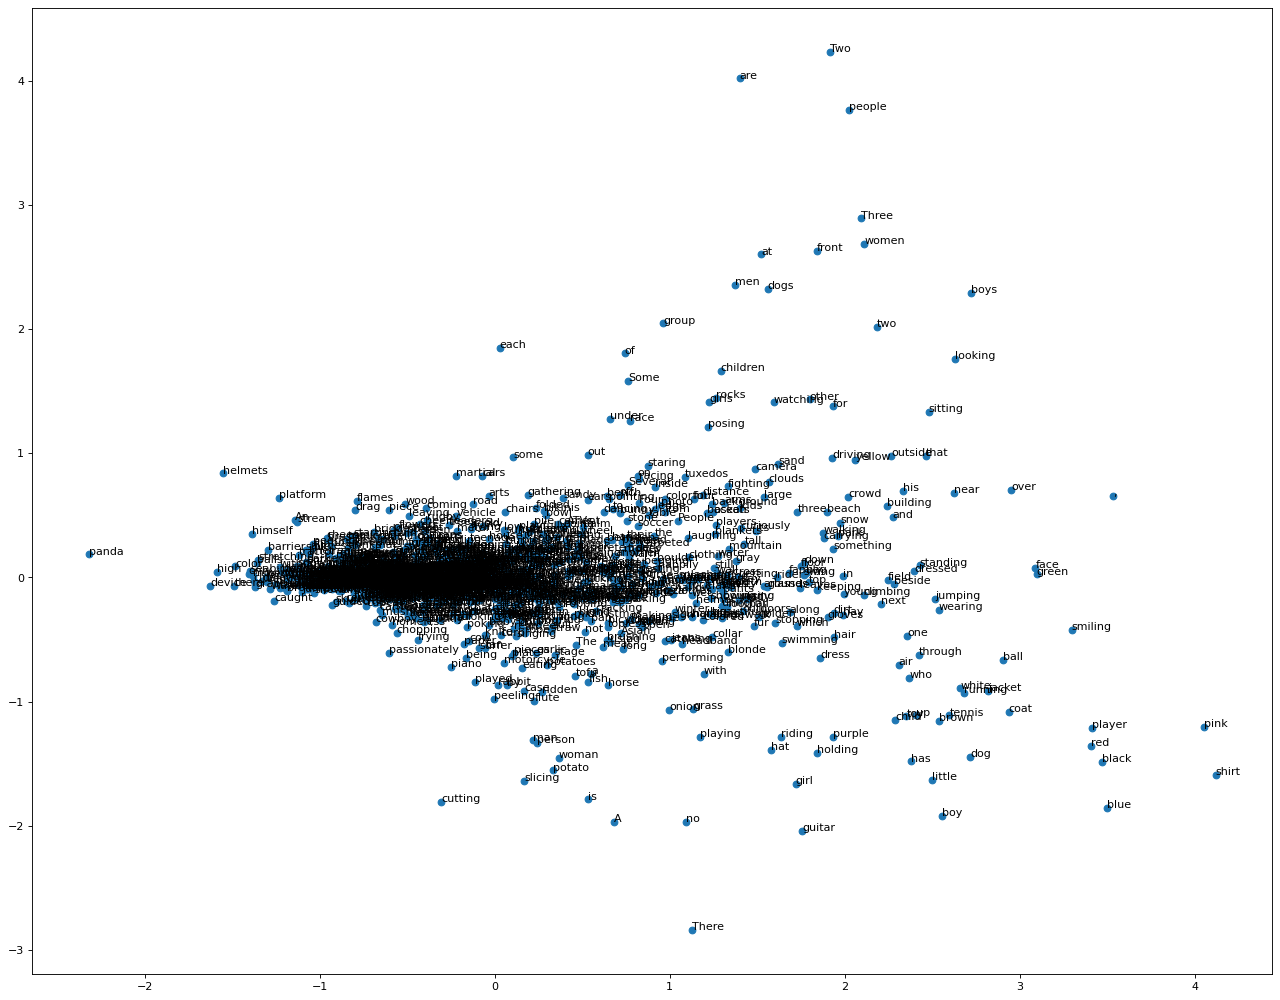

In [44]:
# fit a 2d PCA model to the vectors
X = model_2[model_2.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection

figure(figsize=(20, 16), dpi=80)
plt.scatter(result[:, 0], result[:, 1])
words = list(model_2.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [234]:
model_2.init_sims(replace=True)

<ipython-input-234-92fbe671419f>:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model_2.init_sims(replace=True)


In [235]:
model_2.wv.most_similar('pizza')

[('cheese', 0.9849158525466919),
 ('sprinkling', 0.9831411242485046),
 ('alligator', 0.980039119720459),
 ('patted', 0.9758671522140503),
 ('sausages', 0.9741426706314087),
 ('shredded', 0.9737246036529541),
 ('ramp', 0.9713654518127441),
 ('someone', 0.9690715670585632),
 ('dropped', 0.9668125510215759),
 ('doctor', 0.9662946462631226)]

In [185]:
model_2.wv.most_similar(['a', 'woman', 'is', 'playing'])

[('of', 0.992853581905365),
 ('are', 0.9917856454849243),
 ('dog', 0.9896623492240906),
 ('in', 0.9868097305297852),
 ('the', 0.9863860607147217),
 ('and', 0.9850439429283142),
 ('on', 0.9847042560577393),
 ('man', 0.9843924045562744),
 ('with', 0.9810254573822021),
 ('The', 0.9655666351318359)]

In [ ]:
A man is sprinkling shredded cheese on a pizza',
 'A man is putting seasoning on a pizza',
 'A man is doing a card trick',

In [245]:
similarity_two_words = model_2.wv.similarity(['A', 'man', 'is', 'putting', 'seasoning', 'on', 'a', 'pizza'],
                                             ['A', 'man', 'is', 'sprinkling', 'shredded', 'cheese', 'on', 'a', 'pizza'])
print("Please provide the similarity between these two words:")
print(similarity_two_words)

ValueError: shapes (8,100) and (9,100) not aligned: 100 (dim 1) != 9 (dim 0)

In [246]:
similarity_two_words = model_2.wv.similarity( 'seasoning','sprinkling')
print("Please provide the similarity between these two words:")
print(similarity_two_words)

Please provide the similarity between these two words:
0.93801576


In [239]:
dissimlar_words = model_2.wv.doesnt_match('Someone is beautifully playing the piano'.split())
print(dissimlar_words)

the


In [186]:
model_2.wv.most_similar('woman', topn=30)

[('dog', 0.9971209764480591),
 ('of', 0.9969750642776489),
 ('playing', 0.9958195686340332),
 ('man', 0.9954290986061096),
 ('in', 0.9947142601013184),
 ('on', 0.99430251121521),
 ('and', 0.9939059615135193),
 ('with', 0.9919837713241577),
 ('are', 0.9877668619155884),
 ('a', 0.9874593019485474),
 ('the', 0.9863038063049316),
 ('The', 0.979899525642395),
 ('A', 0.9303878545761108),
 ('is', 0.9142385721206665)]

In [250]:
from lib.sentence2vec import Sentence2Vec

ModuleNotFoundError: No module named 'lib.sentence2vec'

ERROR: Could not find a version that satisfies the requirement lib.sentence2vec
ERROR: No matching distribution found for lib.sentence2vec
Note: you may need to restart the kernel to use updated packages.


 Clustering prediction given a sentence

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import numpy



# vectorization of the texts
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(sent)
# used words (axis in our multi-dimensional space)
words = vectorizer.get_feature_names()
print("words", words)


n_clusters=6
number_of_seeds_to_try=10
max_iter = 300
number_of_process=2 # seads are distributed
model = KMeans(n_clusters=n_clusters, max_iter=max_iter, n_init=number_of_seeds_to_try, n_jobs=number_of_process).fit(X)

labels = model.labels_
# indices of preferible words in each cluster
ordered_words = model.cluster_centers_.argsort()[:, ::-1]

print("centers:", model.cluster_centers_)
print("labels", labels)
print("intertia:", model.inertia_)

texts_per_cluster = numpy.zeros(n_clusters)
for i_cluster in range(n_clusters):
    for label in labels:
        if label==i_cluster:
            texts_per_cluster[i_cluster] +=1 

print("Top words per cluster:")
for i_cluster in range(n_clusters):
    print("Cluster:", i_cluster, "texts:", int(texts_per_cluster[i_cluster])),
    for term in ordered_words[i_cluster, :10]:
        print("\t"+words[term])

print("\n")
print("Prediction")

text_to_predict = "i was riding a horse at the park?"
Y = vectorizer.transform([text_to_predict])
predicted_cluster = model.predict(Y)[0]
texts_per_cluster[predicted_cluster]+=1

print(text_to_predict)
print("Cluster:", predicted_cluster, "texts:", int(texts_per_cluster[predicted_cluster])),
for term in ordered_words[predicted_cluster, :10]:
    print("\t"+words[term])

words ['absent', 'accident', 'acrobatics', 'added', 'adding', 'adults', 'aiming', 'aimlessly', 'air', 'airborne', 'aircraft', 'airplane', 'alligator', 'alongside', 'amazedly', 'american', 'amusedly', 'animal', 'anxiously', 'approaching', 'arcade', 'area', 'aren', 'arm', 'armbands', 'arms', 'arrangement', 'arts', 'asian', 'asleep', 'athletes', 'attached', 'attentively', 'atvs', 'audience', 'away', 'baby', 'background', 'backs', 'bag', 'bale', 'ball', 'balls', 'bamboo', 'banana', 'band', 'bank', 'bare', 'barking', 'barrier', 'bars', 'base', 'baseball', 'basketball', 'baskets', 'bathing', 'battling', 'beach', 'bear', 'bearded', 'beautiful', 'beautifully', 'bed', 'bedroom', 'bee', 'beer', 'beers', 'begging', 'beige', 'belly', 'bench', 'bend', 'bent', 'bib', 'bicycle', 'bicyclist', 'big', 'bike', 'biker', 'bikes', 'bikini', 'bikinis', 'bin', 'bird', 'birdcage', 'biting', 'black', 'blanket', 'blankets', 'block', 'blond', 'blonde', 'blue', 'blurry', 'bmx', 'board', 'boat', 'boiling', 'books',

/Users/mariabrullmartinez/opt/anaconda3/envs/nlp-eda/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"



Cluster: 0 texts: 852
	person
	boy
	people
	child
	playing
	men
	young
	jumping
	wearing
	sitting
Cluster: 1 texts: 101
	playing
	guitar
	man
	piano
	flute
	drums
	singing
	boy
	little
	keyboard
Cluster: 2 texts: 128
	girl
	pink
	hair
	young
	sign
	wearing
	shirt
	beach
	horse
	standing
Cluster: 3 texts: 229
	woman
	slicing
	frying
	cutting
	man
	blue
	riding
	horse
	tofu
	pan
Cluster: 4 texts: 257
	dog
	brown
	running
	ball
	black
	grass
	jumping
	white
	water
	field
Cluster: 5 texts: 433
	man
	riding
	cutting
	horse
	potato
	drawing
	slicing
	standing
	motorcycle
	dancing


Prediction
i was riding a horse at the park?
Cluster: 5 texts: 434
	man
	riding
	cutting
	horse
	potato
	drawing
	slicing
	standing
	motorcycle
	dancing
